In [168]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import random as r
import matplotlib.pyplot as plt

In [ ]:
# -----------------------------
# 1. Load your datasets
# -----------------------------
print("Loading datasets...")
reviews_df = pd.read_csv("./archive/dataset.csv")  # columns: app_id, app_name, review_text


Loading datasets...


AttributeError: 'list' object has no attribute 'keys'

In [173]:
tags_df = pd.read_csv("output.csv")        # columns: APPID, tags

# Convert string representation of dict to actual dict
tags_df['tags'] = tags_df['tags'].apply(lambda x: literal_eval(x))
print(tags_df.head())

# Optional: Keep only tag names (ignore counts)
tags_df['tags'] = tags_df['tags'].apply(lambda d: list(d.keys()) if isinstance(d, dict) else d)

    APPID                                               tags
0      10  {'Action': 5504, 'FPS': 4929, 'Multiplayer': 3...
1    1002  {'2D Fighter': 47, 'Martial Arts': 41, 'Intent...
2  100400       {'Animation & Modeling': 23, 'Software': 11}
3   10090  {'Zombies': 1198, 'World War II': 903, 'FPS': ...
4  100980  {'Animation & Modeling': 38, 'Utilities': 22, ...


In [174]:
# -----------------------------
# 2. Aggregate reviews per game (only games with tags available)
# -----------------------------
print("Aggregating reviews per game...")

reviews_df['app_id'] = reviews_df['app_id'].astype(int)
tags_df['APPID'] = tags_df['APPID'].astype(int)

# Filter reviews to only include games present in tags_df
reviews_with_tags = reviews_df[reviews_df['app_id'].isin(tags_df['APPID'])]
print(reviews_with_tags.head(5))

# Convert review_text to string
reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)

# Filter out reviews shorter than 3 words
reviews_with_tags = reviews_with_tags.loc[reviews_with_tags['review_text'].str.split().str.len() >= 3]

print("Filtered reviews shape:", reviews_with_tags.shape)

# Aggregate reviews per game and keep app_name
game_reviews = (
    reviews_with_tags.groupby('app_id')
    .agg({
        'review_text': lambda texts: " ".join(texts),
        'app_name': 'first'  # keep the first app_name per app_id
    })
    .reset_index()
)
print("Aggregated reviews shape:", game_reviews.shape)

# Merge with tags
game_reviews = game_reviews.merge(tags_df, left_on='app_id', right_on='APPID')
print("Merged game_reviews shape:", game_reviews.shape)

print("Sample data:")
print(game_reviews.head())

Aggregating reviews per game...
   app_id        app_name                                        review_text  \
0      10  Counter-Strike                                    Ruined my life.   
1      10  Counter-Strike  This will be more of a ''my experience with th...   
2      10  Counter-Strike                      This game saved my virginity.   
3      10  Counter-Strike  • Do you like original games? • Do you like ga...   
4      10  Counter-Strike           Easy to learn, hard to master.             

   review_score  review_votes  
0             1             0  
1             1             1  
2             1             0  
3             1             0  
4             1             1  


C:\Users\joris\AppData\Local\Temp\ipykernel_21196\1055335932.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_with_tags['review_text'] = reviews_with_tags['review_text'].astype(str)


Filtered reviews shape: (3991199, 5)
Aggregated reviews shape: (3060, 3)
Merged game_reviews shape: (3060, 5)
Sample data:
   app_id                                        review_text  \
0      10  Ruined my life. This will be more of a ''my ex...   
1      20  When I got this for Christmas in 1999 along wi...   
2      30  Even though its old, its better than Call of D...   
3     130  The cupcake version of Half-Life. Play as Barn...   
4     220  Play and understand why we need Half-Life 3. i...   

                app_name  APPID  \
0         Counter-Strike     10   
1  Team Fortress Classic     20   
2          Day of Defeat     30   
3  Half-Life: Blue Shift    130   
4            Half-Life 2    220   

                                                tags  
0  [Action, FPS, Multiplayer, Shooter, Classic, T...  
1  [Action, FPS, Multiplayer, Classic, Hero Shoot...  
2  [FPS, World War II, Multiplayer, Shooter, Acti...  
3  [FPS, Action, Sci-fi, Singleplayer, Shooter, A...  
4  [FP

In [175]:
# -----------------------------
# 3. Encode text to embeddings
# -----------------------------
print("Encoding text to embeddings...")
model = SentenceTransformer("all-MiniLM-L6-v2")
data = model.encode(game_reviews['review_text'].tolist(), show_progress_bar=True)


Encoding text to embeddings...


Batches: 100%|██████████| 96/96 [06:37<00:00,  4.14s/it] 


In [176]:
# -----------------------------
# 4. Encode tags to multilabel format
# -----------------------------
print("Encoding tags to multilabel format...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(game_reviews['tags'])

Encoding tags to multilabel format...


In [177]:
# -----------------------------
# 5. Train/Test split
# -----------------------------
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, train_ids, test_ids, train_names, test_names = train_test_split(
    data, y, game_reviews['app_id'], game_reviews['app_name'], test_size=0.2, random_state=42
)

Splitting data into train and test sets...


In [178]:
# -----------------------------
# 6. Train multilabel classifier
# -----------------------------
print("Training multilabel classifier...")
clf = OneVsRestClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
clf.fit(X_train, y_train)

Training multilabel classifier...


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 37 is present in all training examples.
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 100 is present in all training examples.
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 129 is present in all training examples.
  warnings.warn(
C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 152 is present in all training examples.
  warnings.warn(
C:\Users\joris\Ap

,estimator,LogisticRegre...max_iter=1000)
,n_jobs,None
,verbose,0
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None


In [179]:
# -----------------------------
# 7. Predict and align with game info
# -----------------------------

actual_tags = mlb.inverse_transform(y_test)

# Get probabilities
probs = clf.predict_proba(X_test)

# Pick top 5 tags per game
top_n = 20
top_n_pred_tags = []
for prob_row in probs:
    top_indices = prob_row.argsort()[-top_n:][::-1]  # indices of top N probs
    top_tags = [mlb.classes_[i] for i in top_indices]
    top_n_pred_tags.append(top_tags)

# Example: print top 5 predicted tags for first 5 games
# gam = r.randint(0, len(test_names)-1)
# for i in range(gam, gam+5):
#     print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
#     print("  Predicted tags:", top_n_pred_tags[i])  # only show tags not in actual
#     print("  Actual tags   :", actual_tags[i])
#     print(f"{len(set(top_n_pred_tags[i]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
#     print()
# -----------------------------
gam = r.randint(0, len(test_names)-1)
for i in range(gam, gam+5):
    print(f"{test_names.iloc[i]} (app_id={test_ids.iloc[i]})")
    print("  Predicted tags:", top_n_pred_tags[i][:len(actual_tags[i])])  # only show tags not in actual
    print("  Actual tags   :", actual_tags[i])
    print(f"{len(set(top_n_pred_tags[i][:len(actual_tags[i])]) & set(actual_tags[i]))}/{len(actual_tags[i])}", "tags correct")
    print()


Blood: One Unit Whole Blood (app_id=299030)
  Predicted tags: ['Gore', 'Classic', 'Violent', 'Boomer Shooter', 'Action', "1990's", 'Shooter', 'Stealth', 'Retro', 'Survival Horror', 'Horror', 'Third-Person Shooter', 'FPS', 'Arena Shooter', 'Third Person', 'Great Soundtrack', 'First-Person', 'Singleplayer', 'Multiplayer', 'Old School']
  Actual tags   : ("1990's", '2.5D', 'Action', 'Adventure', 'Atmospheric', 'Blood', 'Boomer Shooter', 'Classic', 'Dark', 'Difficult', 'FPS', 'First-Person', 'Gore', 'Gothic', 'Horror', 'Old School', 'Retro', 'Shooter', 'Singleplayer', 'Zombies')
12/20 tags correct

GridRunner Revolution (app_id=27810)
  Predicted tags: ['Psychedelic', 'Great Soundtrack', 'Cyberpunk', 'Cult Classic']
  Actual tags   : ('Arcade', 'Indie', 'Psychedelic', "Shoot 'Em Up")
1/4 tags correct

Broken Age (app_id=232790)
  Predicted tags: ['Puzzle', 'Adventure', 'Point & Click', 'Casual', 'Cute', 'Cult Classic', 'Cartoony', '2D', 'Comedy', 'Remake', 'Mystery', 'Fantasy', 'Female Pro

In [180]:
# Example: pred_tags = [['Action','RPG'], ['Action','Multiplayer'], ['RPG','Multiplayer']]
# Flatten the list of lists

def find_top_x(li, x=10, print_output=True):
    flat = np.array([item for sublist in li for item in sublist])

    # Get unique tags and counts
    unique, counts = np.unique(flat, return_counts=True)

    # Sort tags by descending frequency
    sorted_indices = np.argsort(-counts)
    most_common_items = unique[sorted_indices]
    most_common_counts = counts[sorted_indices]

    # Print top 10 tags
    if print_output:
        print("Top tags:")
        for item, count in zip(most_common_items[:x], most_common_counts[:x]):
            print(f"{item}: {count}")
    return most_common_items[:x], most_common_counts[:x]

X=25
top_pred = find_top_x(top_n_pred_tags, x=X, print_output=False)
top_act = find_top_x(actual_tags, x=X, print_output=False)

print(len(top_n_pred_tags), len(actual_tags))
df_compare = pd.DataFrame({
    'pred_Tag': [t for t in top_pred[0]],
    'pred_count': [s for s in top_pred[1]],
    'act_Tag': [t for t in top_act[0]],
    'act_count': [s for s in top_act[1]]
})

df_compare


612 612


,pred_Tag,pred_count,act_Tag,act_count
0,Action,240,Singleplayer,377
1,Adventure,224,Indie,336
2,Indie,214,Action,326
3,Casual,171,Adventure,289
4,Singleplayer,161,Multiplayer,191
5,Strategy,153,Strategy,179
6,Multiplayer,149,Casual,178
7,Simulation,141,2D,141
8,2D,137,RPG,140
9,Shooter,131,Atmospheric,136


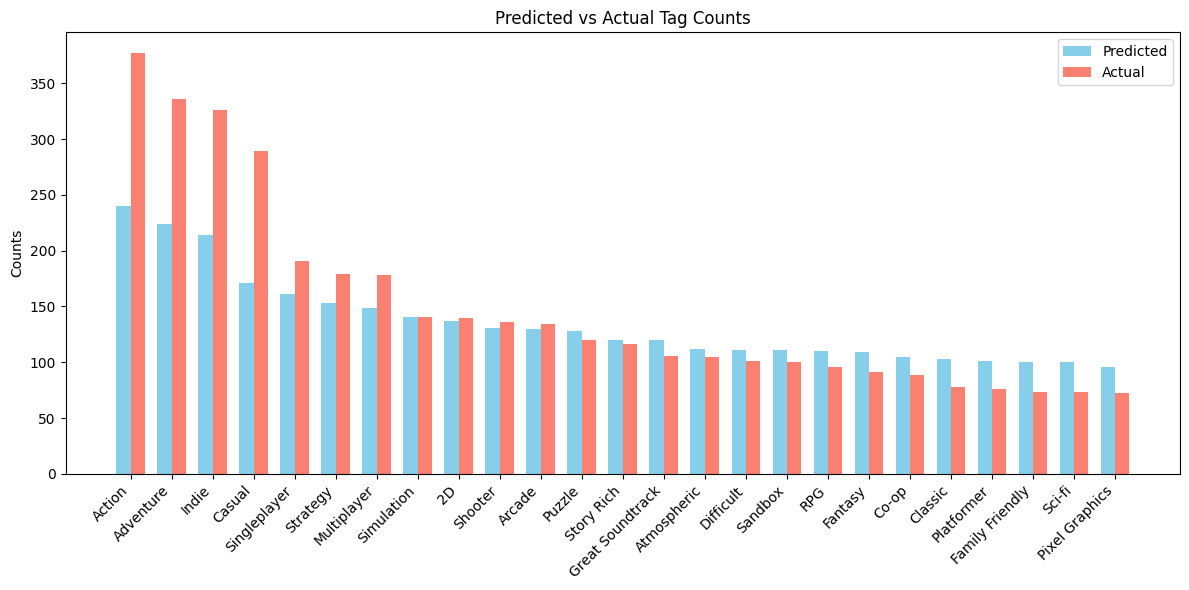

In [181]:

# We'll plot the top 10 predicted tags for clarity
top_n = X
df_top = df_compare.head(top_n)

x = np.arange(top_n)  # positions for each tag
width = 0.35          # width of bars

fig, ax = plt.subplots(figsize=(12,6))

# Bars
ax.bar(x - width/2, df_top['pred_count'], width, label='Predicted', color='skyblue')
ax.bar(x + width/2, df_top['act_count'], width, label='Actual', color='salmon')

# Labels
ax.set_ylabel('Counts')
ax.set_title('Predicted vs Actual Tag Counts')
ax.set_xticks(x)
ax.set_xticklabels(df_top['pred_Tag'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [182]:

def plot_tag_count_distribution_hist(pred_counts, actual_counts, bins=20, title="Tag Count Distribution"):
    """
    Plots the distribution of tag counts using a histogram with bins and a line overlay.
    
    Args:
        pred_counts (array-like): counts of each predicted tag
        actual_counts (array-like): counts of each actual tag
        bins (int or sequence): number of bins or bin edges
        title (str): plot title
    """
    plt.figure(figsize=(12,6))
    
    # Histogram for actual counts
    counts_actual, bin_edges = np.histogram(actual_counts, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.bar(bin_centers, counts_actual, width=(bin_edges[1]-bin_edges[0])*0.4, alpha=0.6,
            label='Actual', color='salmon', edgecolor='black')
    plt.plot(bin_centers, counts_actual, color='red', marker='o', linestyle='-', label='Actual (line)')
    
    # Histogram for predicted counts
    counts_pred, _ = np.histogram(pred_counts, bins=bin_edges)
    plt.bar(bin_centers + (bin_edges[1]-bin_edges[0])*0.4, counts_pred, width=(bin_edges[1]-bin_edges[0])*0.4,
            alpha=0.6, label='Predicted', color='skyblue', edgecolor='black')
    plt.plot(bin_centers, counts_pred, color='blue', marker='o', linestyle='-', label='Predicted (line)')
    
    plt.xlabel("Number of occurrences of a tag")
    plt.ylabel("Number of tags in that bin")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

(365,) (388,)
[240 224 214 171 161 153 149 141 137 131 130 128 120 120 112 111 111 110
 109 105 103 101 100 100  96  96  96  95  92  89  89  89  87  87  87  86
  84  84  80  80  78  77  76  75  75  75  73  73  72  71  70  70  70  68
  67  66  66  66  65  63  63  63  61  61  58  57  56  56  55  54  54  54
  52  52  52  51  51  51  50  50  50  50  50  49  49  49  49  48  48  48
  47  45  45  45  44  44  43  43  42  42  42  42  42  41  41  41  40  40
  40  40  39  39  39  39  39  39  38  38  38  38  37  37  36  36  36  36
  36  35  34  34  34  33  33  33  32  32  31  31  30  30  30  29  29  29
  29  28  28  28  28  27  27  27  27  27  27  27  26  26  26  26  26  26
  26  26  26  25  25  25  25  25  25  25  25  25  25  24  24  24  24  24
  24  24  24  24  23  23  22  21  21  20  20  20  20  19  18  18  18  18
  18  17  17  17  17  17  17  16  16  15  15  15  15  15  15  15  14  14
  14  14  14  14  13  13  13  13  13  13  13  12  12  12  12  12  12  12
  12  12  12  12  11  11  11  11  11 

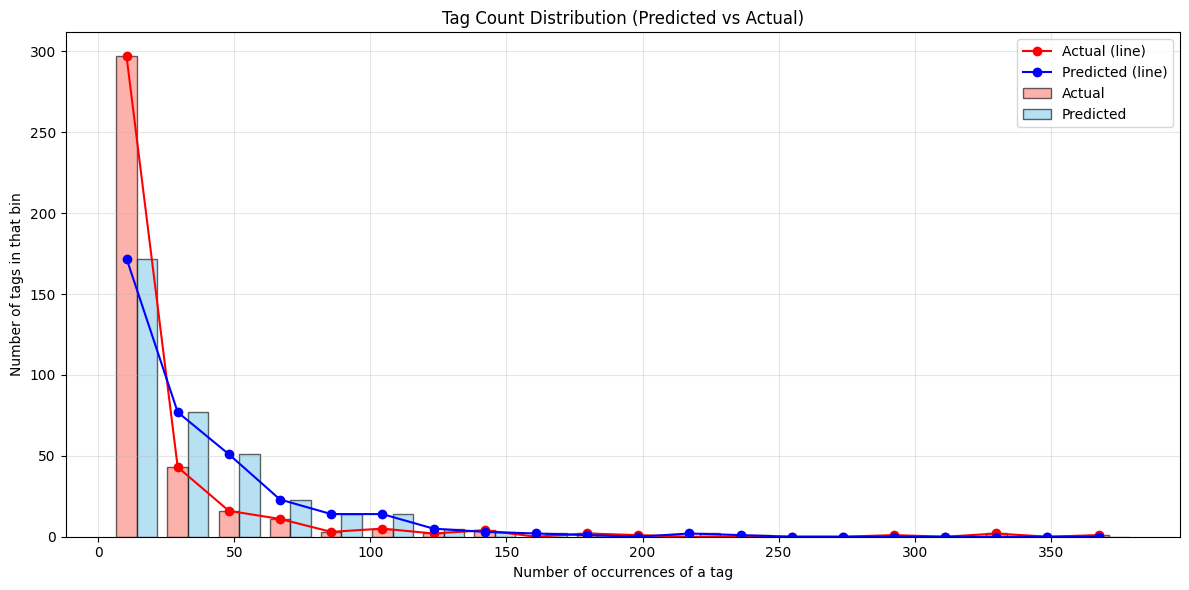

In [ ]:
top_pred = find_top_x(top_n_pred_tags, x=len(top_n_pred_tags), print_output=False)
top_act = find_top_x(actual_tags, x=len(actual_tags), print_output=False)

print((top_pred[1]).shape, (top_act[1]).shape)
print(top_pred[0][-1], top_act[0][-1])
plot_tag_count_distribution_hist(top_pred[1], top_act[1], title="Tag Count Distribution (Predicted vs Actual)")


In [184]:
# Convert top-N predicted tag names to a binary matrix
y_pred = np.zeros_like(y_test)

for i, tags in enumerate(top_n_pred_tags):
    for tag in tags:
        if tag in mlb.classes_:
            idx = list(mlb.classes_).index(tag)
            y_pred[i, idx] = 1



In [185]:
from sklearn.metrics import hamming_loss, f1_score, precision_score, recall_score

# y_test: actual multilabel binary matrix
# y_pred: predicted multilabel binary matrix



# Hamming Loss
hl = hamming_loss(y_test, y_pred)
print("Hamming Loss:", hl)

# Micro-averaged precision, recall, F1 (across all games)
precision = precision_score(y_test, y_pred, average='micro')
recall = recall_score(y_test, y_pred, average='micro')
f1 = f1_score(y_test, y_pred, average='micro')

print(f"Micro Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Macro-averaged F1 (average per tag)
f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 (per tag): {f1_macro:.3f}")


Hamming Loss: 0.04919440644474844
Micro Precision: 0.289, Recall: 0.455, F1: 0.353
Macro F1 (per tag): 0.213


C:\Users\joris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
